In [1]:
import sent2vec
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import  RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from functools import lru_cache
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from sqlitedict import SqliteDict
from tqdm import tqdm
import json

import collections
from rouge_score import rouge_scorer

from collections import OrderedDict

import faiss

from rouge_score import scoring

from scipy.optimize import curve_fit
import scipy.interpolate as interp
from scipy.stats import f_oneway

import random

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yingqiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yingqiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/yingqiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class SentenceTokenizer:
    def __init__(self ):
        self.tokenizer = RegexpTokenizer(r'[A-Za-z]+')
        self.lemmatizer = WordNetLemmatizer()
        self.general_stopwords = set(stopwords.words('english'))

    @lru_cache(100000)
    def lemmatize( self, w ):
        return self.lemmatizer.lemmatize(w)
    
    def tokenize(self, sen, remove_stopwords = False ):
        sen = " ".join([ self.lemmatize(w) for w in self.tokenizer.tokenize( sen.lower() ) if not remove_stopwords or  w not in self.general_stopwords  ])
        return sen

In [3]:
class Sent2vecEncoder:
    def __init__( self, model_path ):
        self.model = sent2vec.Sent2vecModel()
        self.model.load_model(  model_path )
        self.tokenizer = SentenceTokenizer()

    def tokenize_sentences( self, sentences  ):
        tokenized_sentences = []
        for sen in sentences:
            tokenized_sentences.append( self.tokenizer.tokenize( sen ) )
        return tokenized_sentences

    def encode( self, sentences, tokenize = True ):
        if tokenize:
            sentences = self.tokenize_sentences( sentences )
        return self.model.embed_sentences( sentences )

    def normalize_embeddings(self, embeddings ):
        assert len( embeddings.shape ) == 2
        normalized_embeddings = embeddings /(np.linalg.norm( embeddings, axis =1, keepdims=True )+1e-12)
        return normalized_embeddings

In [4]:
class SentenceRanker:
    def __init__( self, model_path ):
        self.encoder = Sent2vecEncoder(model_path)

    def encode(self, sentences, tokenize = True):
        return self.encoder.encode( sentences, tokenize )

    def normalize_embeddings(self, embeddings ):
        assert len( embeddings.shape ) == 2
        normalized_embeddings = embeddings /(np.linalg.norm( embeddings, axis =1, keepdims=True )+1e-12)
        return normalized_embeddings

    def rank_sentences( self, query_sentence, sentences_to_be_ranked, top_n = None ):
        query_embedding = self.normalize_embeddings(self.encode( [query_sentence] ))[0]
        sentences_embedding = self.normalize_embeddings(self.encode( sentences_to_be_ranked ))
        sims = np.dot(sentences_embedding, query_embedding)
        if top_n is None:
            top_n = len(sentences_to_be_ranked)
        I = np.argsort( -sims )[:top_n]  
        D = sims[I]
        return D,I

In [5]:
def rank_local_conclusions(ranker, global_conclusions, local_conclusions, top_n=None):
    if top_n == None:
        top_n = len(local_conclusions)
    D, I = ranker.rank_sentences(" ".join(global_conclusions), local_conclusions, top_n)
    return [local_conclusions[idx] for idx in I]

In [6]:
def get_args_from_body_text(ranker, conclusion, body_text, top_k=None):
    premises = []
    if top_k == None:
        top_k = 1
    for cls in conclusion:
        D, I = ranker.rank_sentences(cls, body_text, top_k+1)
        premises.append([body_text[idx] for idx in I[1:]]) # closest one is the same sentence, need to filter out

    return [sent for premise in premises for sent in premise]

In [7]:
ranker = SentenceRanker(model_path='/mnt/external/yingqiang/sent2vec/sent2vec_600_dim.bin')

In [8]:
scinf_full_text = SqliteDict('../SQLite/scinf-biomed-body-text.sqlite', autocommit=True)

In [9]:
scinf_global_pairs = SqliteDict('../SQLite/scinf-biomed-global-arguments.sqlite', autocommit=True)

In [10]:
scinf_local_pairs_indicator = SqliteDict('../SQLite/scinf-biomed-LAC-indicator.sqlite', autocommit=True)

In [11]:
scinf_local_pairs_intersection = SqliteDict('../SQLite/scinf-biomed-LAC-intersection.sqlite', autocommit=True)

In [12]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)

In [14]:
### use the overlapping ids under the SQLite folder
with open('../SQLite/paper_ids.json', 'r') as f:
    paper_ids = json.load(f)

In [15]:
def average_score_dict(score_dict):
    
    avg_score_dict = {'rouge1':scoring.Score(precision=np.mean([score['rouge1'][0] for score in score_dict.values()]), recall=np.mean([score['rouge1'][1] for score in score_dict.values()]), fmeasure=np.mean([score['rouge1'][2] for score in score_dict.values()])),
                      'rouge2':scoring.Score(precision=np.mean([score['rouge2'][0] for score in score_dict.values()]), recall=np.mean([score['rouge2'][1] for score in score_dict.values()]), fmeasure=np.mean([score['rouge2'][2] for score in score_dict.values()])),
                      'rougeLsum':scoring.Score(precision=np.mean([score['rougeLsum'][0] for score in score_dict.values()]), recall=np.mean([score['rougeLsum'][1] for score in score_dict.values()]), fmeasure=np.mean([score['rougeLsum'][2] for score in score_dict.values()]))
                          }
    return avg_score_dict

In [16]:
def rank_dict_with_key(score_dict):
    return {k: v for k, v in sorted(score_dict.items(), key=lambda item: item[0])}

indicator vs intersection:
    - fetch the first limited_length words in local conclusions/premises, then compare with the global conclusions/premises

In [17]:
### compute for all word lengths

max_length_indicator = 0

rouge_scores_indicator_all = list()

indicator_keys = list()
    
for key in tqdm(paper_ids):
    rouge_scores_indicator = dict()
    try:
        local_premises = scinf_local_pairs_indicator[key]["premise"]
        local_premises = [pre for pre in scinf_local_pairs_indicator[key]["premise"] if pre]
        global_premises = scinf_global_pairs[key]['premise']

        actual_length = len(word_tokenize("\n".join(local_premises)))

        if actual_length > max_length_indicator:
            max_length_indicator = actual_length
        
        if actual_length != 0:
            scores = scorer.score("\n".join(sent_tokenize(global_premises)), "\n".join(word_tokenize("\n".join(local_premises))))
            rouge_scores_indicator[key] = {'rouge':scores, 'length':actual_length}
            rouge_scores_indicator_all.append(rouge_scores_indicator)
            indicator_keys.append(key)

        else:
            continue
            
    except KeyError:
        continue     

100%|██████████| 27924/27924 [04:31<00:00, 102.70it/s]


In [18]:
max_length_intersection = 0

rouge_scores_intersection_all = list()

intersection_keys = list()

for key in tqdm(paper_ids):
    rouge_scores_intersection = dict()
    try:

        local_premises = scinf_local_pairs_intersection[key]["premise"]
        global_premises = scinf_global_pairs[key]['premise']

        actual_length = len(word_tokenize(local_premises))

        if actual_length > max_length_intersection:
            max_length_intersection = actual_length

        if actual_length != 0:
            scores = scorer.score("\n".join(sent_tokenize(global_premises)), "\n".join(word_tokenize(local_premises)))
            rouge_scores_intersection[key] = {'rouge':scores, 'length':actual_length}
            rouge_scores_intersection_all.append(rouge_scores_intersection)
            intersection_keys.append(key)
                
        else:
            continue

    except KeyError:
        continue

100%|██████████| 27924/27924 [26:58<00:00, 17.25it/s] 


In [20]:
common_rouge_scores_indicator_all = [rouge_scores_indicator_all[i] for i in range(len(rouge_scores_indicator_all)) if indicator_keys[i] in joint_keys]

In [21]:
common_rouge_scores_intersection_all = [rouge_scores_intersection_all[i] for i in range(len(rouge_scores_intersection_all)) if intersection_keys[i] in joint_keys]

In [22]:
sorted_rouge_scores_indicator_all = sorted(common_rouge_scores_indicator_all, key=lambda d: list(d.keys()))
sorted_rouge_scores_intersection_all = sorted(common_rouge_scores_intersection_all, key=lambda d: list(d.keys()))

In [24]:
avg_rouge_indicator_records = dict()
avg_rouge_intersection_records = dict()

grouped_rouge_indicator_records = dict()
grouped_rouge_intersection_records = dict()

for i in tqdm(range(len(joint_keys))):
    
    indicator_scores = {key:value['rouge'] for key, value in sorted_rouge_scores_indicator_all[i].items()}
    intersection_scores = {key:value['rouge'] for key, value in sorted_rouge_scores_intersection_all[i].items()} 
    
    indicator_length = list(sorted_rouge_scores_indicator_all[i].values())[0]['length']
    intersection_length = list(sorted_rouge_scores_intersection_all[i].values())[0]['length']

    if indicator_length not in grouped_rouge_indicator_records.keys():
        grouped_rouge_indicator_records[indicator_length] = list()
        indicator_dict_temp = {"paper_id":list(indicator_scores.keys())[0], 'rouge':indicator_scores}
        grouped_rouge_indicator_records[indicator_length].append(indicator_dict_temp)
    else:
        indicator_dict_temp = {"paper_id":list(indicator_scores.keys())[0], 'rouge':indicator_scores}
        grouped_rouge_indicator_records[indicator_length].append(indicator_dict_temp)
        
    if intersection_length not in grouped_rouge_intersection_records.keys():
        grouped_rouge_intersection_records[intersection_length] = list()
        intersection_dict_temp = {"paper_id":list(intersection_scores.keys())[0], 'rouge':intersection_scores}
        grouped_rouge_intersection_records[intersection_length].append(intersection_dict_temp)
    else:
        intersection_dict_temp = {"paper_id":list(intersection_scores.keys())[0], 'rouge':intersection_scores}
        grouped_rouge_intersection_records[intersection_length].append(intersection_dict_temp)

100%|██████████| 23044/23044 [00:00<00:00, 81489.01it/s] 


In [25]:
def average_grouped_rouge_records(rouge_record_dict):
    
    new_rouge_record_dict = dict()
    
    for length in tqdm(rouge_record_dict.keys()):
        records = rouge_record_dict[length]
        rouge1_pr, rouge1_rc, rouge1_fm = list(), list(), list()
        rouge2_pr, rouge2_rc, rouge2_fm = list(), list(), list()
        rougeL_pr, rougeL_rc, rougeL_fm = list(), list(), list()
        for record in records:
            rouge1_pr.append(list(record['rouge'].values())[0]['rouge1'][0]) 
            rouge1_rc.append(list(record['rouge'].values())[0]['rouge1'][1]) 
            rouge1_fm.append(list(record['rouge'].values())[0]['rouge1'][2]) 
            
            rouge2_pr.append(list(record['rouge'].values())[0]['rouge2'][0])
            rouge2_rc.append(list(record['rouge'].values())[0]['rouge2'][1])
            rouge2_fm.append(list(record['rouge'].values())[0]['rouge2'][2])
            
            rougeL_pr.append(list(record['rouge'].values())[0]['rougeLsum'][0])
            rougeL_rc.append(list(record['rouge'].values())[0]['rougeLsum'][1])
            rougeL_fm.append(list(record['rouge'].values())[0]['rougeLsum'][2])
            
        avg_score_dict = {'rouge1':scoring.Score(precision=np.mean(rouge1_pr), recall=np.mean(rouge1_rc), fmeasure=np.mean(rouge1_fm)),
                          'rouge2':scoring.Score(precision=np.mean(rouge2_pr), recall=np.mean(rouge2_rc), fmeasure=np.mean(rouge2_fm)),
                          'rougeLsum':scoring.Score(precision=np.mean(rougeL_pr), recall=np.mean(rougeL_rc), fmeasure=np.mean(rougeL_fm))
                          }
        
        new_rouge_record_dict[length] = avg_score_dict
        
    return {k: v for k, v in sorted(new_rouge_record_dict.items(), key=lambda item: item[0])}

In [26]:
ranked_avg_rouge_indicator_records = average_grouped_rouge_records(grouped_rouge_indicator_records)
ranked_avg_rouge_intersection_records = average_grouped_rouge_records(grouped_rouge_intersection_records)

100%|██████████| 1671/1671 [00:00<00:00, 6411.99it/s]


In [27]:
common_lengths = list(set(list(ranked_avg_rouge_indicator_records.keys())) & set(list(ranked_avg_rouge_intersection_records.keys())))
common_lengths = sorted(common_lengths)
common_lengths = [length for length in common_lengths if length <= 300]

In [28]:
def plot_trendline(x, y, order, color, linewidth):
    parameter = np.polyfit(x, y, order)
    f = np.poly1d(parameter)
    plt.plot(x, f(x), 'r--', color=color, linewidth=linewidth)

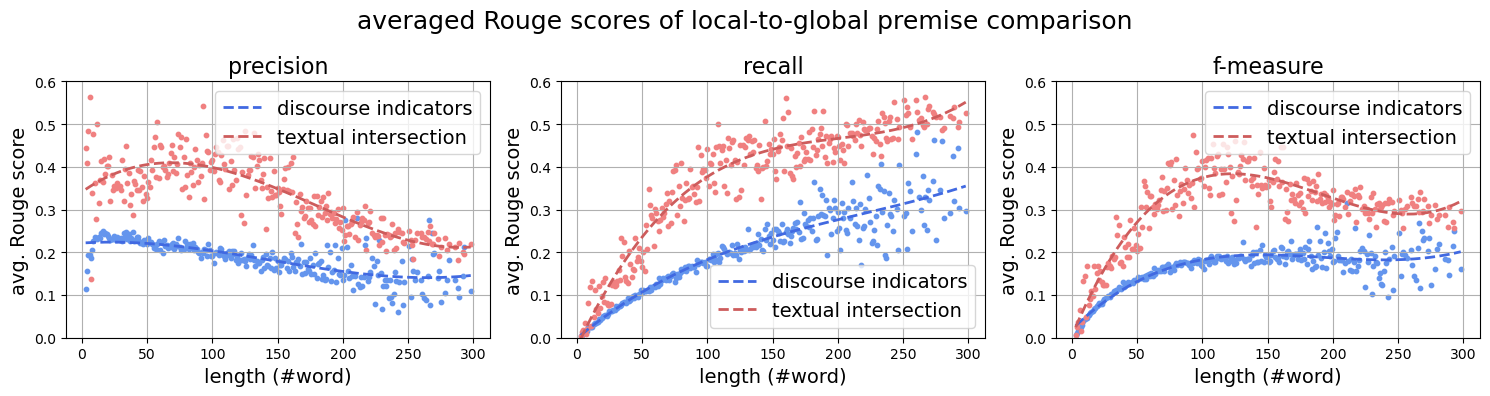

In [29]:
ax = plt.figure(figsize=(15, 4))

indicator_x = list(ranked_avg_rouge_indicator_records.keys())
intersection_x = list(ranked_avg_rouge_intersection_records.keys())

x_label = common_lengths

plt.subplot(131)

lpgp_pr_indicator = [np.mean([ranked_avg_rouge_indicator_records[length]['rouge1'][0],
                             ranked_avg_rouge_indicator_records[length]['rouge2'][0],
                             ranked_avg_rouge_indicator_records[length]['rougeLsum'][0]])
                     for length in common_lengths]

lpgp_pr_intersection = [np.mean([ranked_avg_rouge_intersection_records[length]['rouge1'][0],
                             ranked_avg_rouge_intersection_records[length]['rouge2'][0],
                             ranked_avg_rouge_intersection_records[length]['rougeLsum'][0]]) 
                     for length in common_lengths]


lpgp_pr_indicator_outlier = [i for i,j in enumerate(lpgp_pr_indicator) if j == 1.0]
lpgp_pr_intersection_outlier = [i for i,j in enumerate(lpgp_pr_intersection) if j == 1.0]

lpgp_pr_indicator = [j for i,j in enumerate(lpgp_pr_indicator) if i not in lpgp_pr_indicator_outlier]
lpgp_pr_intersection = [j for i,j in enumerate(lpgp_pr_intersection) if i not in lpgp_pr_intersection_outlier]

x_label_indicator_pr = [j for i,j in enumerate(x_label) if i not in lpgp_pr_indicator_outlier]
x_label_intersection_pr = [j for i,j in enumerate(x_label) if i not in lpgp_pr_intersection_outlier]

plt.scatter(x_label_indicator_pr, lpgp_pr_indicator, s=10, color='cornflowerblue')
plt.scatter(x_label_intersection_pr, lpgp_pr_intersection, s=10, color='lightcoral')
plot_trendline(x_label_indicator_pr, lpgp_pr_indicator, 3, color='royalblue', linewidth=2)
plot_trendline(x_label_intersection_pr, lpgp_pr_intersection, 3, color='indianred', linewidth=2)

plt.xlabel('length (#word)', fontsize=14)
plt.ylabel('avg. Rouge score', fontsize=14)
plt.legend(labels=['discourse indicators', 'textual intersection'], fontsize=14)
plt.title('precision', fontsize=16)
plt.ylim([0, 0.6])
plt.grid(True)

plt.subplot(132)

lpgp_rc_indicator = [np.mean([ranked_avg_rouge_indicator_records[length]['rouge1'][1],
                             ranked_avg_rouge_indicator_records[length]['rouge2'][1],
                             ranked_avg_rouge_indicator_records[length]['rougeLsum'][1]]) 
                     for length in common_lengths]

lpgp_rc_intersection = [np.mean([ranked_avg_rouge_intersection_records[length]['rouge1'][1],
                             ranked_avg_rouge_intersection_records[length]['rouge2'][1],
                             ranked_avg_rouge_intersection_records[length]['rougeLsum'][1]]) 
                     for length in common_lengths]


lpgp_rc_indicator_outlier = [i for i,j in enumerate(lpgp_rc_indicator) if j == 1.0]
lpgp_rc_intersection_outlier = [i for i,j in enumerate(lpgp_rc_intersection) if j == 1.0]

lpgp_rc_indicator = [j for i,j in enumerate(lpgp_rc_indicator) if i not in lpgp_rc_indicator_outlier]
lpgp_rc_intersection = [j for i,j in enumerate(lpgp_rc_intersection) if i not in lpgp_rc_intersection_outlier]

x_label_indicator_rc = [j for i,j in enumerate(x_label) if i not in lpgp_rc_indicator_outlier]
x_label_intersection_rc = [j for i,j in enumerate(x_label) if i not in lpgp_rc_intersection_outlier]

plt.scatter(x_label_indicator_rc, lpgp_rc_indicator, s=10, color='cornflowerblue')
plt.scatter(x_label_intersection_rc, lpgp_rc_intersection, s=10, color='lightcoral')
plot_trendline(x_label_indicator_rc, lpgp_rc_indicator, 3, color='royalblue', linewidth=2)
plot_trendline(x_label_intersection_rc, lpgp_rc_intersection, 3, color='indianred', linewidth=2)

plt.xlabel('length (#word)', fontsize=14)
plt.ylabel('avg. Rouge score', fontsize=14)
plt.legend(labels=['discourse indicators', 'textual intersection'], fontsize=14)
plt.title('recall', fontsize=16)
plt.ylim([0, 0.6])
plt.grid(True)

plt.subplot(133)

lpgp_fm_indicator = [np.mean([ranked_avg_rouge_indicator_records[length]['rouge1'][2],
                             ranked_avg_rouge_indicator_records[length]['rouge2'][2],
                             ranked_avg_rouge_indicator_records[length]['rougeLsum'][2]]) 
                     for length in common_lengths]

lpgp_fm_intersection = [np.mean([ranked_avg_rouge_intersection_records[length]['rouge1'][2],
                             ranked_avg_rouge_intersection_records[length]['rouge2'][2],
                             ranked_avg_rouge_intersection_records[length]['rougeLsum'][2]]) 
                     for length in common_lengths]


lpgp_fm_indicator_outlier = [i for i,j in enumerate(lpgp_fm_indicator) if j == 1.0]
lpgp_fm_intersection_outlier = [i for i,j in enumerate(lpgp_fm_intersection) if j == 1.0]

lpgp_fm_indicator = [j for i,j in enumerate(lpgp_fm_indicator) if i not in lpgp_fm_indicator_outlier]
lpgp_fm_intersection = [j for i,j in enumerate(lpgp_fm_intersection) if i not in lpgp_fm_intersection_outlier]

x_label_indicator_fm = [j for i,j in enumerate(x_label) if i not in lpgp_fm_indicator_outlier]
x_label_intersection_fm = [j for i,j in enumerate(x_label) if i not in lpgp_fm_intersection_outlier]
    
plt.scatter(x_label_indicator_fm, lpgp_fm_indicator, s=10, color='cornflowerblue')
plt.scatter(x_label_intersection_fm, lpgp_fm_intersection, s=10, color='lightcoral')
plot_trendline(x_label_indicator_fm, lpgp_fm_indicator, 3, color='royalblue', linewidth=2)
plot_trendline(x_label_intersection_fm, lpgp_fm_intersection, 3, color='indianred', linewidth=2)

plt.xlabel('length (#word)', fontsize=14)
plt.ylabel('avg. Rouge score', fontsize=14)
plt.legend(labels=['discourse indicators', 'textual intersection'], fontsize=14)
plt.title('f-measure', fontsize=16)
plt.ylim([0, 0.6])
plt.grid(True)

ax.suptitle('averaged Rouge scores of local-to-global premise comparison', fontsize=18)
ax.tight_layout()
plt.savefig('limited_length_lpgp_direct_p1c1_new_PDTB.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# compute the average f-measure for Rouge-N

indicator_r1_fm = np.mean([ranked_avg_rouge_indicator_records[length]['rouge1'][2] for length in common_lengths])
indicator_r2_fm = np.mean([ranked_avg_rouge_indicator_records[length]['rouge2'][2] for length in common_lengths])
indicator_rL_fm = np.mean([ranked_avg_rouge_indicator_records[length]['rougeLsum'][2] for length in common_lengths])

intersection_r1_fm = np.mean([ranked_avg_rouge_intersection_records[length]['rouge1'][2] for length in common_lengths])
intersection_r2_fm = np.mean([ranked_avg_rouge_intersection_records[length]['rouge2'][2] for length in common_lengths])
intersection_rL_fm = np.mean([ranked_avg_rouge_intersection_records[length]['rougeLsum'][2] for length in common_lengths])

print('averaged indicator R-1 f-measure:', indicator_r1_fm)
print('averaged indicator R-2 f-measure:', indicator_r2_fm)
print('averaged indicator R-L f-measure:', indicator_rL_fm)

print('==================================================')

print('averaged intersection R-1 f-measure:', intersection_r1_fm)
print('averaged intersection R-2 f-measure:', intersection_r2_fm)
print('averaged intersection R-L f-measure:', intersection_rL_fm)

averaged indicator R-1 f-measure: 0.23759547838786252
averaged indicator R-2 f-measure: 0.04854435741364162
averaged indicator R-L f-measure: 0.20920041810633158
averaged intersection R-1 f-measure: 0.38091421841679995
averaged intersection R-2 f-measure: 0.20076563213716708
averaged intersection R-L f-measure: 0.33808336657123755
